In [1]:
from typing import Callable, List, TypeVar, Tuple

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.random import default_rng

from simulated_annealing.algorithm import simple_simulated_annealing, SAResult
from simulated_annealing.neighbors_generator import generate_2opt_neighbor, generate_2swap_neighbor

T = TypeVar("T")
REPS = 10
SEEDS = np.random.randint(200, size=10)

# Experiments

In [2]:
def shape_progress(result: SAResult) -> pd.DataFrame:
    return pd.DataFrame({
        "Iteration": np.arange(len(result.b_progress)),
        "Best cost": result.b_progress,
        "Current cost": result.c_progress,
        "Acceptance rate": result.acceptance_rate,
    })


def shuffle(lst: List[T]) -> List[T]:
    rng = default_rng()
    lst_cp = lst.copy()
    rng.shuffle(lst_cp)
    return lst_cp


def generate_path_distance_computer(fp: str) -> Tuple[Callable[[List[int]], float], int]:
    data = np.loadtxt(fp)
    n = data.shape[0]

    def compute_pd(path: List[int]) -> float:
        return np.sum([data[path[i], path[(i + 1) % n]] for i in range(n)])

    return compute_pd, n


def experiment(data_set: str,
               nbr: Callable[[List[int]], List[int]],
               name: str,
               max_iters=10_000,
               seeds=np.random.randint(100, size=REPS),
               temp_factor=0.95,
               initial_temp=None) -> pd.DataFrame:
    obj_f, n = generate_path_distance_computer(data_set)
    results = []

    for i in range(REPS):
        np.random.seed(seeds[i])
        s0 = shuffle([i for i in range(n)])
        results.append(
            simple_simulated_annealing(obj_f, nbr, s0,
                                       temp_factor=temp_factor,
                                       initial_temperature=initial_temp,
                                       max_iterations=max_iters)
        )

    df = pd.concat([shape_progress(r) for r in results])
    df["Type"] = name
    return df

In [3]:
def plot(df: pd.DataFrame, optimal: float) -> Tuple[plt.Figure, Tuple]:
    fig, (a1, a2, a3) = plt.subplots(1, 3, width_ratios=[0.3, 0.35, 0.35], figsize=(15, 3))
    sns.lineplot(df, x="Iteration", y="Acceptance rate", ax=a1)
    a2.axhline(optimal, color="black")
    sns.lineplot(df, x="Iteration", y="Best cost", hue="Type", ax=a2)
    a3.axhline(optimal, color="black")
    sns.lineplot(df, x="Iteration", y="Current cost", hue="Type", ax=a3)

    return fig, (a1, a2, a3)

In [4]:
# gr17_2swap_df = experiment("data/gr17_d.txt", generate_2swap_neighbor, "SA 2-swap",
#                            max_iters=1500, seeds=SEEDS)
# gr17_2opt_df = experiment("data/gr17_d.txt", generate_2opt_neighbor, "SA 2-opt",
#                           max_iters=1500, seeds=SEEDS)
# gr17_df = pd.concat([gr17_2swap_df, gr17_2opt_df])
# gr17_df.to_csv("results/sa_gr17.csv", index=False)

In [5]:
# %%time
# gr17_fig, _ = plot(gr17_df, 2085)
# gr17_fig.savefig("../images/gr17_sa", dpi=600, bbox_inches="tight")

In [6]:
# fri26_2swap_df = experiment("data/fri26_d.txt", generate_2swap_neighbor, "SA 2-swap",
#                             max_iters=2500, seeds=SEEDS)
# fri26_2opt_df = experiment("data/fri26_d.txt", generate_2opt_neighbor, "SA 2-opt",
#                            max_iters=2500, seeds=SEEDS)
# fri26_df = pd.concat([fri26_2opt_df, fri26_2swap_df])
# fri26_df.to_csv("results/sa_fri26.csv", index=False)

In [7]:
# %%time
# fri26_fig, _ = plot(fri26_df, 937)
# fri26_fig.savefig("../images/fri26_sa", dpi=600, bbox_inches="tight")

In [8]:
%%time
att48_2swap_df = experiment("data/att48_d.txt", generate_2swap_neighbor, "SA 2-swap",
                            max_iters=5000, seeds=SEEDS)
att48_2opt_df = experiment("data/att48_d.txt", generate_2opt_neighbor, "SA 2-opt",
                           max_iters=5000, seeds=SEEDS)
att48_df = pd.concat([att48_2opt_df, att48_2swap_df])
att48_df.to_csv("results/sa_att48.csv", index=False)

CPU times: user 3.01 s, sys: 99.5 ms, total: 3.11 s
Wall time: 3.04 s


/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-

CPU times: user 5min 11s, sys: 656 ms, total: 5min 12s
Wall time: 5min 12s


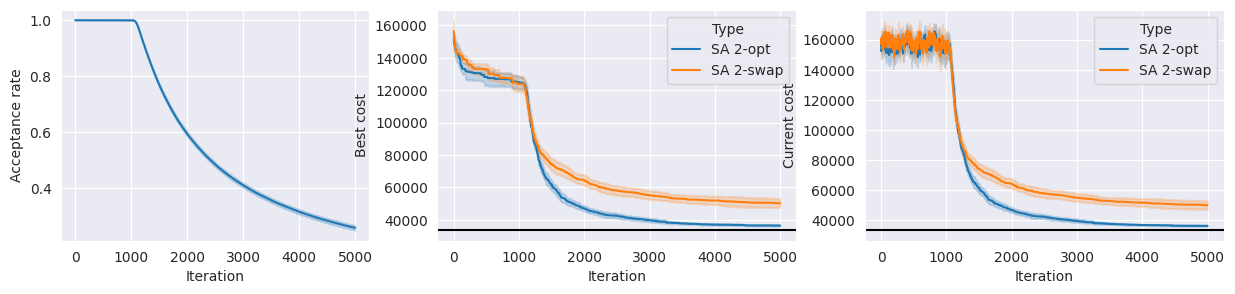

In [9]:
%%time
att48_fig, _ = plot(att48_df, 33523)
att48_fig.savefig("../images/att48_sa", dpi=600, bbox_inches="tight")

# Comparison with Hill Climbing

In [10]:
hc_gr17 = pd.read_csv("~/muic/ma395_heuristic/homework/hw1/results/gr17.csv")
hc_fri26 = pd.read_csv("~/muic/ma395_heuristic/homework/hw1/results/fri26.csv")
hc_att48 = pd.read_csv("~/muic/ma395_heuristic/homework/hw1/results/att48.csv")

sa_gr17 = pd.read_csv("results/sa_gr17.csv")
sa_fri26 = pd.read_csv("results/sa_fri26.csv")
sa_att48 = pd.read_csv("results/sa_att48.csv")

gr17 = pd.concat([sa_gr17, hc_gr17]).drop(["Current cost", "Acceptance rate", "Trial"], axis=1)
fri26 = pd.concat([sa_fri26, hc_fri26]).drop(["Current cost", "Acceptance rate", "Trial"], axis=1)
att48 = pd.concat([sa_att48, hc_att48]).drop(["Current cost", "Acceptance rate", "Trial"], axis=1)

/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/s

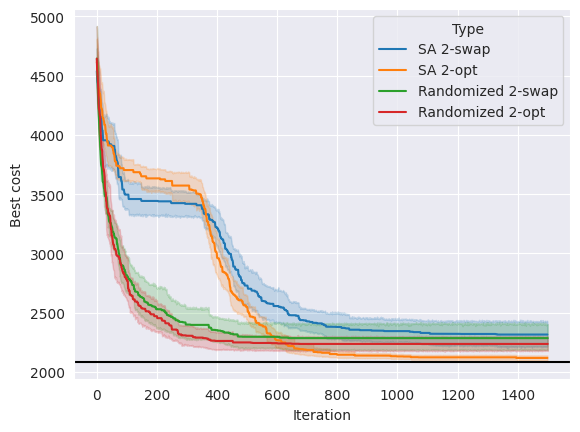

In [11]:
plt.axhline(2085, color="black")
sns.lineplot(gr17, x="Iteration", y="Best cost", hue="Type")
plt.savefig("../images/gr17-with-hc.png", dpi=600, bbox_inches="tight")

/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/s

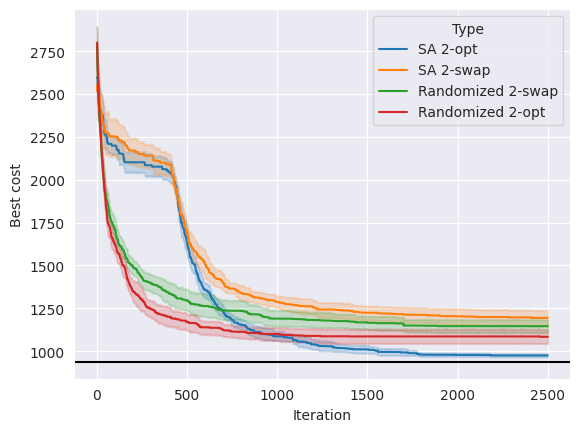

In [12]:
plt.axhline(937, color="black")
sns.lineplot(fri26, x="Iteration", y="Best cost", hue="Type")
plt.savefig("../images/fri26-with-hc.png", dpi=600, bbox_inches="tight")

/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nawat/.cache/pypoetry/virtualenvs/code-SenwC5NH-py3.10/lib/python3.10/site-packages/s

CPU times: user 4min 2s, sys: 583 ms, total: 4min 3s
Wall time: 4min 2s


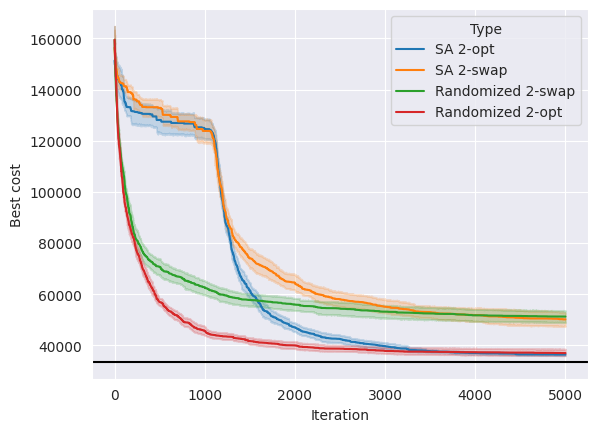

In [13]:
%%time
plt.axhline(33523, color="black")
sns.lineplot(att48, x="Iteration", y="Best cost", hue="Type")
plt.savefig("../images/att48-with-hc.png", dpi=600, bbox_inches="tight")